# Анализ пресс-релизов Банка России

**Описание исследования:**

Мы получили тексты пресс-релизов с сайта ЦБ, и теперь хотим увидеть взаимосвязь этих текстов с решением, по ключевой ставке.

**Цель исследования:**

Получить знания, о зависимости текстовых данных пресс-релизов и решениями по ключевой ставки и использовать их в построении модели предсказания ключевой ставки.

**План работы:**
1) Загрузка и предобработка данных.
2) Объединение таблиц и создание целевых переменных.
3) Провести анализ текстов: расчет средней, минимальной и максимальной длины текстов (визуализация
распределения), частотный анализ слов и n-грамм, извлечение биграмм и триграмм, статистики по
символам и словам, распределение частей речи.
4) Изучить связь текстовых признаков с целевой переменной.
5) Визуализировать данные:
    - распределения классов;
    - облако наиболее частотных слов и биграмм для выявления ключевых тем (Word Clouds);
    - методы снижения размерности (например, t-SNE) для визуализации текстовых представлений.
6) Провести первичную предобработку теста:
    - оценить и обработать пропуски, дубликаты; очистить текст от шумовых данных: ненужных символов, HTML-тегов,
специальных символов;
    - преобразовать регистр, исключить стоп-слова, провести токенизацию (разбить на слова, предложения, символы), лемматизацию или стемминг.
7) Оформить вывод о структуре данных, их особенностях и потенциальных проблемах на основе
проведенного разведочного анализа данных.

**Описание данных:**

Данные получены путем скрапинга с официального сайти Центрального банка.

Таблица пресс-релизов(`cbr-press-releases.csv`), содержит следующие столбцы:
- `date` - дата опубликования пресс-релиза;
- `link` - ссылка на пресс-релиз;
- `title` - заголовок пресс-релиза;
- `release` - текст пресс-релиза.

Таблица процентных ставок, содержит следующие столбцы:
- `date` - дата опубликования процентных ставок;
- `rate` - величина процентной ставки;

In [1]:
# импортируем библиотеки
import re
from collections import Counter
import locale
from datetime import datetime
from typing import Union

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
import tqdm
from pymystem3 import Mystem


# Устанавливаем тему для графиков
sns.set(style="darkgrid")
nltk.download('stopwords', quiet=True);

## Загрузка и предобработка данных пресс-релизов.

Загрузим данные и взглянем на первые и последние 5 строчек.

In [2]:
df = pd.read_csv('../data/raw-cbr-press-releases.csv')
df

,date,link,title,release
0,13 сентября 2024 г.,/press/pr/?file=13092024_133000Key.htm,Банк России принял решение повысить ключевую с...,\n \nСовет директоров Банка России 13 сентября...
1,26 июля 2024 г.,/press/pr/?file=26072024_133000Key.htm,Банк России принял решение повысить ключевую с...,\n \nСовет директоров Банка России 26 июля 202...
2,7 июня 2024 г.,/press/pr/?file=07062024_133000Key.htm,Банк России принял решение сохранить ключевую ...,\n \nСовет директоров Банка России 7 июня 2024...
3,26 апреля 2024 г.,/press/pr/?file=26042024_133000key.htm,Банк России принял решение сохранить ключевую ...,\n \nСовет директоров Банка России 26 апреля 2...
4,22 марта 2024 г.,/press/pr/?file=22032024_133000key.htm,Банк России принял решение сохранить ключевую ...,\n \nСовет директоров Банка России 22 марта 20...
...,...,...,...,...
95,13 декабря 2013 г.,/press/pr/?file=131213_133004stavka_table.htm,О ключевой ставке Банка России,\nСовет директоров Банка России 13 декабря 201...
96,8 ноября 2013 г.,/press/pr/?file=131108_133008stavka_+table.htm,О ключевой ставке Банка России,\nСовет директоров Банка России 8 ноября 2013 ...
97,14 октября 2013 г.,/press/pr/?file=131014_133001refi_rate_tab.htm,О ключевой ставке Банка России,"\nПресс-служба Банка России сообщает, что Сове..."
98,13 сентября 2013 г.,/press/pr/?file=130913_1350427l.htm,О системе процентных инструментов денежно-кред...,\n О системе процентных инструментов денежно...


К ссылкам стоит добавить адрес главной страницы, тексты релизов стоит обработать и убрать лишние символы перевода строки. Дату надо привести к соответствующему типу данных. Посмотрим какие типы данных у наших переменных и количество пропущенных значений.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     100 non-null    object
 1   link     100 non-null    object
 2   title    100 non-null    object
 3   release  100 non-null    object
dtypes: object(4)
memory usage: 3.3+ KB


У нас 100 наблюдений в нашем датасете. Пропущенные значения отсутствуют. Дату, как уже упоминалось выше стоит превести к типу данных `date`.

In [4]:
locale.setlocale(
    category=locale.LC_ALL,
    locale="Russian"
)

def calc_date(value):
    day, month, year, _ = value.split()
    month = month[:3].replace('мая', 'май')
    return datetime.strptime(' '.join([day, month, year]), '%d %b %Y')

df.date = df.date.map(calc_date)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     100 non-null    datetime64[ns]
 1   link     100 non-null    object        
 2   title    100 non-null    object        
 3   release  100 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 3.3+ KB


Теперь порядок с типами данных. Добавим адрес главной страницы сайта ЦБ к ссылкам:

In [5]:
df.link = 'http://www.cbr.ru' + df.link

Проверим данные на дубликаты.

In [6]:
print(f'Количество дубликатов по дате и названию - {df.duplicated(subset=["date", "title"]).sum()}')

Количество дубликатов по дате и названию - 0


Посмотрим есть ли у нас релизы опубликованные в один день.

In [7]:
print(f'Количество дубликатов по дате - {df.duplicated(subset=["date"]).sum()}')

Количество дубликатов по дате - 2


Взглянем на эти релизы.

In [8]:
indexes = df[df.duplicated(subset=["date"], keep=False)].index

for index in indexes:
    release = df.loc[index]
    print(release.date)
    print('-' * 80, end=' ')
    for i in range(0, len(release.release), 80):
        
        print(release.release[i:i+80])

2015-09-11 00:00:00
-------------------------------------------------------------------------------- 
В целях оперативного информирования пользователей о макроэкономических тенденци
ях, складывающихся в сфере внешнеэкономической деятельности, Банк России вводит 
в практику ежемесячные сообщения об оценке ключевых агрегатов платежного баланса
 Российской Федерации. 
Данные будут размещаться в рубрике Комментарии Банка Рос
сии раздела Пресс-центр официального сайта Банка России.При использовании матери
ала ссылка на Пресс-службу Банка России обязательна.

2015-09-11 00:00:00
-------------------------------------------------------------------------------- 
Совет директоров Банка России 11 сентября 2015 года принял решение сохранить кл
ючевую ставку на уровне 11,00% годовых, учитывая увеличение инфляционных рисков 
при сохранении рисков существенного охлаждения экономики. В августе произошло зн
ачительное ухудшение внешнеэкономической конъюнктуры. Под воздействием курсовой 
динамики выросл

Мы можем заметить, что два релиза из четырех не связаны с решением банка россии по ключевой ставке. Удалим эти наблюдения из выборки.

In [9]:
df.drop_duplicates(subset=['date'], keep='last', inplace=True)

У нас есть пресс-релизы, которые не связаны с изменением процентной ставки, посмотрим на них.

In [10]:
indexes = df[df.title.str.contains('О публикации Обзора ключевых показателей') | df.title.str.contains('О фиксированном времени публикации ключевой')].index
for index in indexes:
    release = df.loc[index]
    print(release.date)
    print('-' * 80)
    print(release.release)

2015-12-29 00:00:00
--------------------------------------------------------------------------------

Банк России, следуя наилучшим практикам распространения данных, с 1 января 2016 года вводит единый порядок публикации ключевой информации по статистике внешнего сектора — данные будут размещаться на официальном сайте Банка России в фиксированное время 16.00 мск. 
Даты публикации статистических данных, размещаемых в фиксированное время, содержатся в Календаре публикаций официальной статистической информации: 
http://www.cbr.ru/statistics/indcalendar/.
Новый порядок публикации обеспечит пользователям более удобные условия получения ключевой статистической информации и позволит эффективно планировать работу с этими данными.При использовании материала ссылка на Пресс-службу Банка России обязательна.

2015-05-06 00:00:00
--------------------------------------------------------------------------------
Банк России начинает публиковать на официальном сайте в информационно-телекоммуникационной 

Удалим эти наблюдения.

In [11]:
df = df[~(df.title.str.contains('О публикации Обзора ключевых показателей') | df.title.str.contains('О фиксированном времени публикации ключевой'))]

## Загрузка и предобработка данных величины ключевых ставок.

Загрузим данные и посмотрим на первые и последние пять строчек.

In [12]:
df_rates = pd.read_csv('../data/key-rates-cbr.csv')
df_rates

,date,rate
0,17.09.2013,5.5
1,18.09.2013,5.5
2,19.09.2013,5.5
3,20.09.2013,5.5
4,23.09.2013,5.5
...,...,...
2763,04.10.2024,19.0
2764,07.10.2024,19.0
2765,08.10.2024,19.0
2766,09.10.2024,19.0


На первый взляд ошибок нет. Посмотрим общую информацию о таблице.

In [13]:
df_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768 entries, 0 to 2767
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    2768 non-null   object 
 1   rate    2768 non-null   float64
dtypes: float64(1), object(1)
memory usage: 43.4+ KB


Пропущенные значения отсутствуют, а вот дату стоит привести к формату даты.

In [14]:
df_rates.date = pd.to_datetime(df_rates.date, dayfirst=True)

Проверим данные на дубликаты по дате.

In [15]:
print(f'Количество дубликатов дат -', end=' ')
print(f'{df_rates.duplicated(subset="date").sum()}')

Количество дубликатов дат - 0


В таблице процентных ставок, ставка в день релиза не изменяется, а изменяется только на следующий день. Давайте сдвинем дату на 2 строчки.

In [16]:
df_rates.date = df_rates.date.shift(2)

## Объединение таблиц и cоздание целевых переменных.

Объеденим наши данные по дате.

In [17]:
df = df.merge(right=df_rates, how='left', on='date')
df

,date,link,title,release,rate
0,2024-09-13,http://www.cbr.ru/press/pr/?file=13092024_1330...,Банк России принял решение повысить ключевую с...,\n \nСовет директоров Банка России 13 сентября...,19.0
1,2024-07-26,http://www.cbr.ru/press/pr/?file=26072024_1330...,Банк России принял решение повысить ключевую с...,\n \nСовет директоров Банка России 26 июля 202...,18.0
2,2024-06-07,http://www.cbr.ru/press/pr/?file=07062024_1330...,Банк России принял решение сохранить ключевую ...,\n \nСовет директоров Банка России 7 июня 2024...,16.0
3,2024-04-26,http://www.cbr.ru/press/pr/?file=26042024_1330...,Банк России принял решение сохранить ключевую ...,\n \nСовет директоров Банка России 26 апреля 2...,16.0
4,2024-03-22,http://www.cbr.ru/press/pr/?file=22032024_1330...,Банк России принял решение сохранить ключевую ...,\n \nСовет директоров Банка России 22 марта 20...,16.0
...,...,...,...,...,...
91,2014-02-14,http://www.cbr.ru/press/pr/?file=14022014_1333...,О ключевой ставке Банка России,\nСовет директоров Банка России 14 февраля 201...,5.5
92,2013-12-13,http://www.cbr.ru/press/pr/?file=131213_133004...,О ключевой ставке Банка России,\nСовет директоров Банка России 13 декабря 201...,5.5
93,2013-11-08,http://www.cbr.ru/press/pr/?file=131108_133008...,О ключевой ставке Банка России,\nСовет директоров Банка России 8 ноября 2013 ...,5.5
94,2013-10-14,http://www.cbr.ru/press/pr/?file=131014_133001...,О ключевой ставке Банка России,"\nПресс-служба Банка России сообщает, что Сове...",5.5


Создадим переменную `target` которая будет показывать насколько изменится процентная ставка на следующем решении.

In [18]:
df['target'] = df.rate.shift(1) - df.rate
df

,date,link,title,release,rate,target
0,2024-09-13,http://www.cbr.ru/press/pr/?file=13092024_1330...,Банк России принял решение повысить ключевую с...,\n \nСовет директоров Банка России 13 сентября...,19.0,NaN
1,2024-07-26,http://www.cbr.ru/press/pr/?file=26072024_1330...,Банк России принял решение повысить ключевую с...,\n \nСовет директоров Банка России 26 июля 202...,18.0,1.0
2,2024-06-07,http://www.cbr.ru/press/pr/?file=07062024_1330...,Банк России принял решение сохранить ключевую ...,\n \nСовет директоров Банка России 7 июня 2024...,16.0,2.0
3,2024-04-26,http://www.cbr.ru/press/pr/?file=26042024_1330...,Банк России принял решение сохранить ключевую ...,\n \nСовет директоров Банка России 26 апреля 2...,16.0,0.0
4,2024-03-22,http://www.cbr.ru/press/pr/?file=22032024_1330...,Банк России принял решение сохранить ключевую ...,\n \nСовет директоров Банка России 22 марта 20...,16.0,0.0
...,...,...,...,...,...,...
91,2014-02-14,http://www.cbr.ru/press/pr/?file=14022014_1333...,О ключевой ставке Банка России,\nСовет директоров Банка России 14 февраля 201...,5.5,1.5
92,2013-12-13,http://www.cbr.ru/press/pr/?file=131213_133004...,О ключевой ставке Банка России,\nСовет директоров Банка России 13 декабря 201...,5.5,0.0
93,2013-11-08,http://www.cbr.ru/press/pr/?file=131108_133008...,О ключевой ставке Банка России,\nСовет директоров Банка России 8 ноября 2013 ...,5.5,0.0
94,2013-10-14,http://www.cbr.ru/press/pr/?file=131014_133001...,О ключевой ставке Банка России,"\nПресс-служба Банка России сообщает, что Сове...",5.5,0.0


In [19]:
df[df.target.isna()]

,date,link,title,release,rate,target
0,2024-09-13,http://www.cbr.ru/press/pr/?file=13092024_1330...,Банк России принял решение повысить ключевую с...,\n \nСовет директоров Банка России 13 сентября...,19.0,NaN
95,2013-09-13,http://www.cbr.ru/press/pr/?file=130913_134305...,О процентных ставках по операциям Банка России,\n Департамент внешних и общественных связей Б...,NaN,NaN


У нас получилось 2 пропущенных значения в переменной `target`. Самое последнее наблюдение, потому что мы не знаем следующего решения по ключевой ставки, удалим это наблюдение. А пропуск в самом первом наблюдении заполним нулем, так как мы знаем, что следующее решение было сохранить процентную ставку. 

In [20]:
df.loc[df.date == df.date.min(), 'rate'] = 5.5
df.loc[df.date == df.date.min(), 'target'] = 0
df.dropna(subset=['target'], inplace=True)

Создадим переменную `target_category`, которая будет равна 1 если `target` положительный, -1 если `target` отрицательный и 0 если `target` рпавен 0.

In [21]:
def calc_target_category(value):
    if value > 0:
        return 1
    elif value < 0:
        return -1
    else:
        return 0
    

df['target_category'] = df.target.map(calc_target_category)

## Исследовательский анализ.

In [23]:
COLORS = {
    0: '#1A4E1A',
    1: '#A03B2A',
    -1: '#4D6D7F'
}

### Распределение целевой переменной.

Посмотрим как распределена переменная `target`.

Общее количество наблюдений - 95


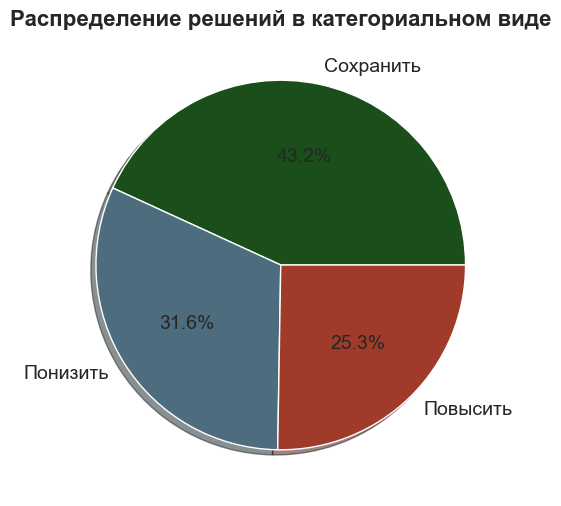

In [24]:
data = df.target_category.value_counts().reset_index()
print(f'Общее количество наблюдений - {df.shape[0]}')
colors = [COLORS[0], COLORS[-1], COLORS[1]]

# Создаем круговую диаграмму
plt.figure(figsize=(6, 6))  # Устанавливаем размер фигуры
plt.pie(
    data['count'], 
    labels=['Сохранить', 'Понизить', 'Повысить'], 
    colors=colors, 
    autopct='%1.1f%%',
    textprops={'fontsize': 14},
    shadow=True,
)

# Устанавливаем заголовок
plt.title(
    'Распределение решений в категориальном виде', 
    fontsize=16,
    fontweight="bold"
)

# Отображаем диаграмму
plt.show()

Наблюдается, небольшой дисбаланс классов, у нас больше всего наблюдений с решением сохранить ключевую ставку, а меньше всего повысить.

### Длина текстов

Посмотрим распределение длин текстов пресс-релизов.

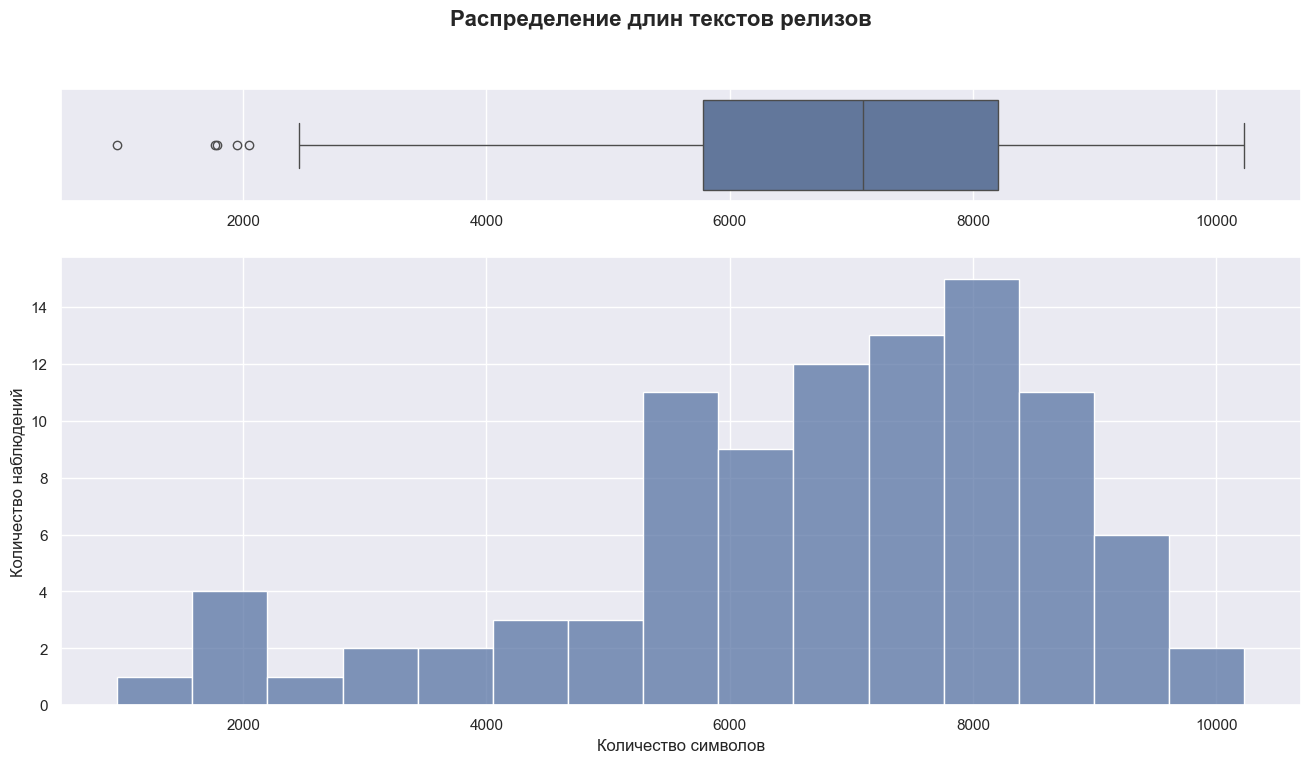

Средняя длина текстов - 6769.96 символов
Самый длинный текст - 10230 символов
Самый короткий текст - 964 символов


In [25]:
fig, axes = plt.subplots(
    nrows=2, ncols=1, sharex=False, 
    gridspec_kw={"height_ratios": (.2, .8)},
    figsize=(16, 8)
)

sns.boxplot(
    data=df, 
    x=df.release.str.len(), 
    ax=axes[0], 
    orient='h', 
    color='#5975A4',
)

sns.histplot(
    data=df, 
    x=df.release.str.len(), 
    color='#5975A4',
    bins=15
    )

axes[0].set_xlabel('')
axes[1].set_ylabel('Количество наблюдений', fontsize=12)
axes[1].set_xlabel('Количество символов', fontsize=12)

fig.suptitle('Распределение длин текстов релизов', 
            fontsize=16,
            fontweight="bold",
)
plt.show()
print(f'Средняя длина текстов - {df.release.str.len().mean():.2f} символов')
print(f'Самый длинный текст - {df.release.str.len().max()} символов')
print(f'Самый короткий текст - {df.release.str.len().min()} символов')

Можно заметить, что как правило длина релизов составляет от 5500 символов до 9000 символов. Посмотрим распределение длины текстов, в разрезе целевой переменной.

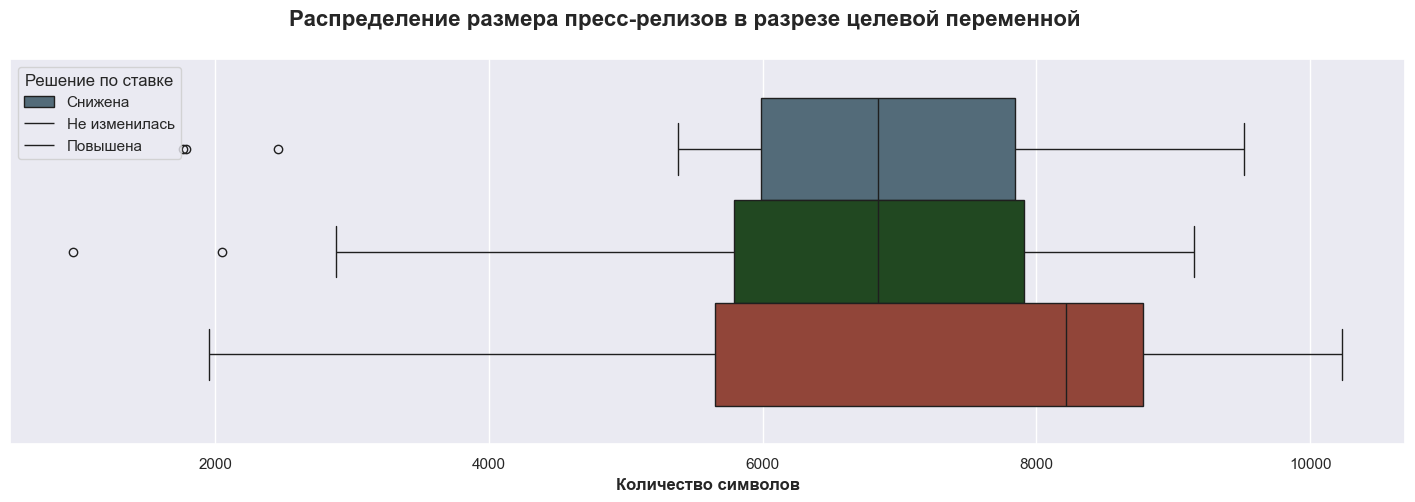

In [26]:
# Устанавливаем размер графика
plt.figure(figsize=(18, 5))

# Строим гистограмму для числового признака с разделением по признаку оттока (churn)
sns.boxplot(
    data=df, 
    x=df.release.str.len(), 
    hue='target_category', 
    palette=COLORS,
    )

# Устанавливаем заголовок графика
plt.suptitle(
    'Распределение размера пресс-релизов в разрезе целевой переменной', 
    fontsize=16, 
    fontweight='bold'
)

# Устанавливаем название оси X
plt.xlabel('Количество символов', fontweight='bold')

# Устанавливаем название оси Y
plt.ylabel('')

# Настройка легенды
plt.legend(
    title='Решение по ставке',              
    labels=['Снижена', 'Не изменилась', 'Повышена'],                     
)

# Отображаем график
plt.show()

Можем заметить, что за длинными релизами чаще следует повышение ключевой ставки. 

### Частотный анализ

Проведем частотный анализ слов в пресс-релизах. Реализуем функцию, которая будет обрабатывать тексты:
- приводить тескт к нижнему регистру;
- Все символы не являющиеся русскими буквами заменять на пробелы;
- Приводить все слова к нормальной форме;
- удалять стоп слова.

In [27]:
def preprocessing_release(text: str) -> list[str]:
    stop_words = set(nltk.corpus.stopwords.words('russian'))
    regex = re.compile('[^а-я ]')
    mystem = Mystem()

    text = text.lower()
    text = regex.sub(' ', text)
    text = filter(lambda w: not w.isspace(), mystem.lemmatize(text))
    text = list(filter(lambda w: w not in stop_words and len(w) != 1, text))
    return text

Отдельно обработаем все тексты разных категорий целевой переменной. И посчитаем относительную частоту каждого слова.

In [28]:
def get_preprocess_texts(df: pd.DataFrame, class_cat: Union[int, None]=None) -> list[str]:
    if class_cat is None:
        df = df.release
    else:
        df = df.loc[df.target_category == class_cat, 'release']
        
    texts_raw = ' '.join(df.to_list())
    texts = preprocessing_release(texts_raw)
    return texts


def get_freq(texts: list[str]) -> dict[str, float]:
    cnt_words = Counter(texts)
    num_words = sum(cnt_words.values())
    cnt_words = {k: v / num_words for k, v in cnt_words.items()}
    cnt_words = dict(sorted(cnt_words.items(), key=lambda w: -w[1]))
    return cnt_words

In [29]:
texts_neg_class = get_preprocess_texts(df, -1)
texts_zero_class = get_preprocess_texts(df, 0)
texts_pos_class = get_preprocess_texts(df, 1)
texts_all_class = get_preprocess_texts(df)

In [30]:
cnt_words_neg_class = get_freq(texts_neg_class)
cnt_words_zero_class = get_freq(texts_zero_class)
cnt_words_pos_class = get_freq(texts_pos_class)
cnt_words_all_classes = get_freq(texts_all_class)

Визуализируем 30 самых популярных слов для всех наблюдений.

In [31]:
def plot_all_words(data: pd.Series, title: str, ylabel: str) -> None:
    plt.figure(figsize=(18, 10))
    sns.barplot(data=data[:30], orient='h', color='#5975A4')
    plt.suptitle(title, fontsize=16, fontweight="bold")
    plt.xlabel('Относительная частота', fontsize=12)
    plt.ylabel(ylabel)
    plt.show()

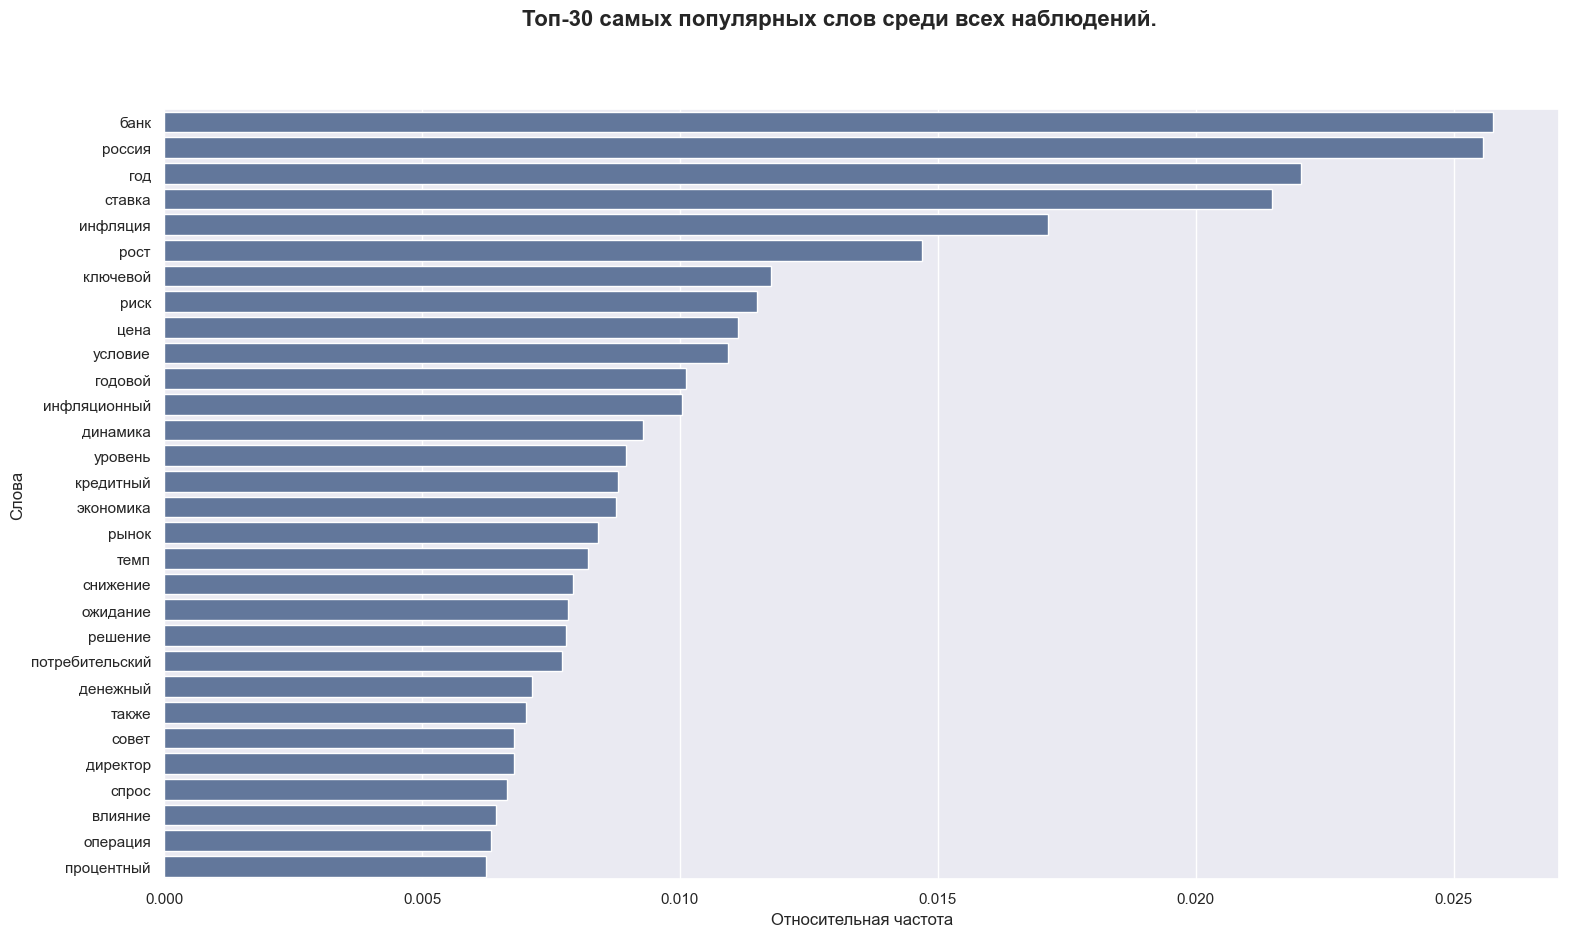

In [32]:
plot_all_words(
    pd.Series(cnt_words_all_classes),
    'Топ-30 самых популярных слов среди всех наблюдений.',
    'Слова'
    )

Вычислим слова которые входят в Топ-30 среди всех классов целевой переменной.

In [33]:
def calc_common_words(*cnt_words_dic: dict) -> set[str]:
    result = set(list(cnt_words_dic[0].keys())[:30])

    for dic in cnt_words_dic[1:]:
        result.intersection_update(set(list(dic.keys())[:30]))
    
    return result

common_words = calc_common_words(cnt_words_neg_class, cnt_words_zero_class, cnt_words_pos_class)

Посмотрим как различается относительная частота встречаемости самых популярных слов среди разных классов целевой переменной.

In [34]:
def plot_words_per_class(data: dict[int, dict], title: str, ylabel: str, common_words: set[str]) -> None:
    fig, axes = plt.subplots(1, 3, figsize=(16, 9))
    fig.suptitle(
        title, 
        fontsize=16, 
        fontweight='bold'
        )
    
    for i, (k, v) in enumerate(data.items()):
        words = pd.Series(v)[:30].reset_index()
        words.columns = ('word', 'freq')
        words['color'] = words['word'].apply(
            lambda w: 'grey' if w in common_words else COLORS[k]
        )
        words.set_index('word', inplace=True)
        sns.barplot(
            data=words,
            ax=axes[i],
            orient='h',
            y='word',
            x='freq',
            hue='word',
            legend=False,
            palette=words['color'].to_dict()
        )
        axes[i].set_ylabel(ylabel)
        axes[i].set_xlabel('Относительная частота')
    axes[0].set_title('Ставка снизится')
    axes[1].set_title('Ставка не изменится')
    axes[2].set_title('Ставка повысится')

    plt.show()

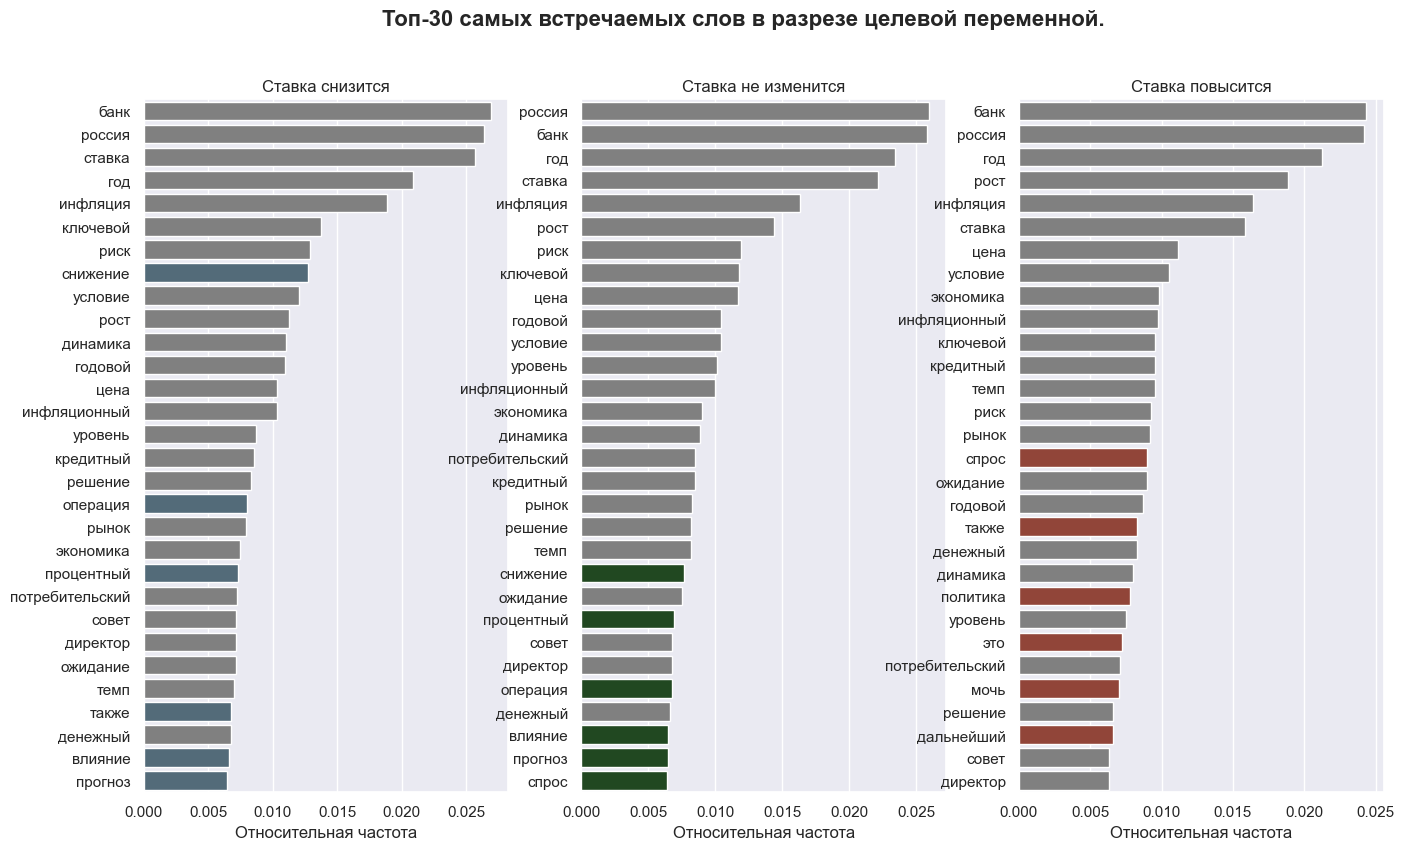

In [35]:
data = {-1: cnt_words_neg_class, 0: cnt_words_zero_class, 1: cnt_words_pos_class}
plot_words_per_class(
    data,
    'Топ-30 самых встречаемых слов в разрезе целевой переменной.',
    '',
    common_words
)

Слова которые встречаются во всех категориях отмечены серым цветом. Можем увидеть что слово `спрос` встречается чаще, если следующую ставку поднимают, а слово снижение встречается чаще, если следующую ставку снижают. Но в целом тут сложно заметить какие-то особенности, давайте попробуем удалить из каждого списка слов, слова которые встречаются во всех категориях и снова посмотрим на этот график.

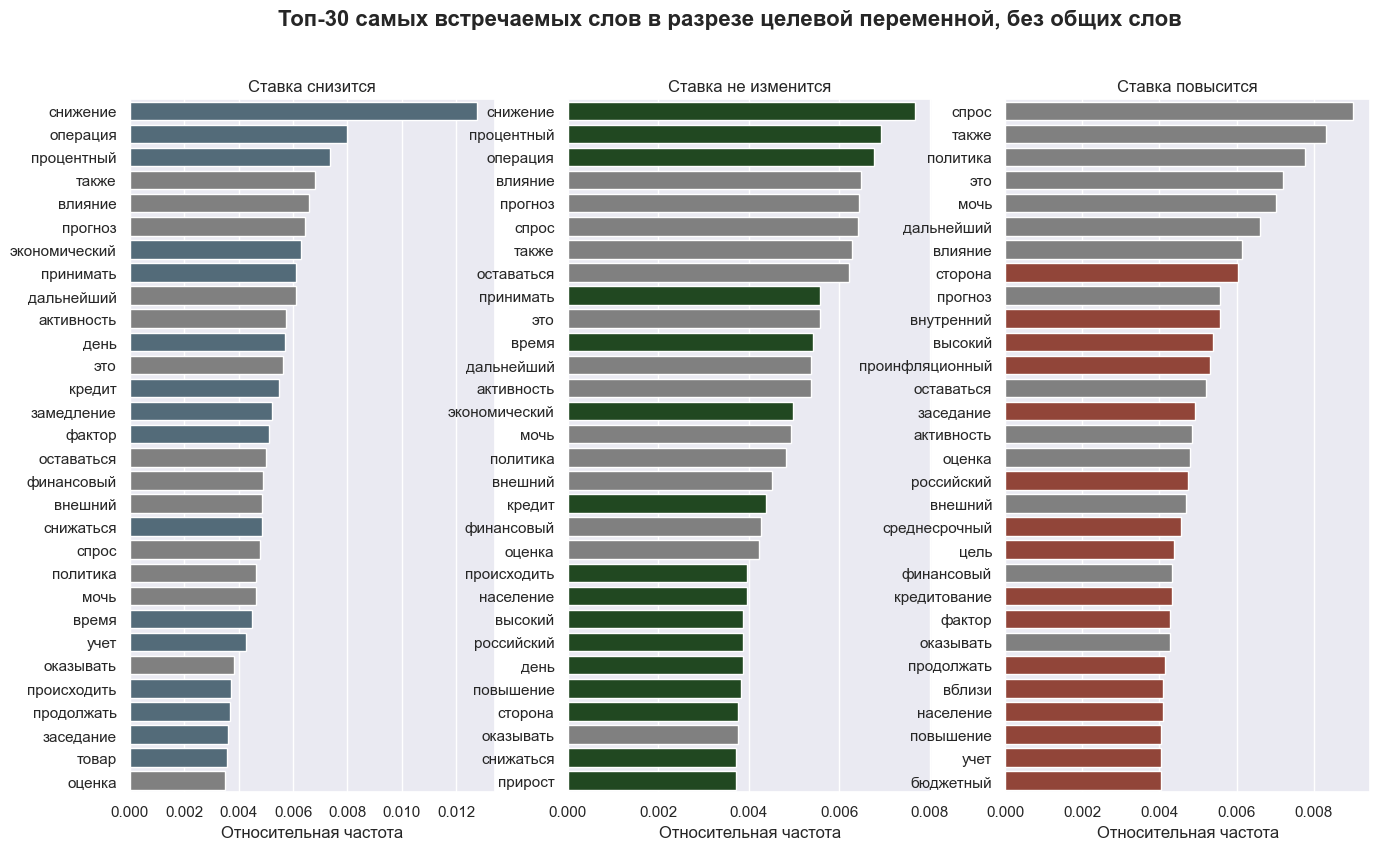

In [36]:
for word in common_words:
    for value in data.values():
        del value[word]

common_words = calc_common_words(cnt_words_neg_class, cnt_words_zero_class, cnt_words_pos_class)

plot_words_per_class(
    data,
    'Топ-30 самых встречаемых слов в разрезе целевой переменной, без общих слов',
    '',
    common_words
)

Можем заметить, что тексты релизов предшествующие понижению или сохранению ставки имеют больше общих слов, чем релизы предшествующие повышению ставки. По одному слову можно догадываться в каком контексте оно содержится, но это не всегда так. Давайте сделаем все тоже самое для пар слов(биграм). Вычислим частотность биграм для каждого класса.

In [37]:
cnt_bigram_all_class = get_freq(nltk.ngrams(texts_all_class, 2))
cnt_bigram_all_class = {str(k): v for k, v in cnt_bigram_all_class.items()}
cnt_bigram_neg_class = get_freq(nltk.ngrams(texts_neg_class, 2))
cnt_bigram_neg_class = {str(k): v for k, v in cnt_bigram_neg_class.items()}
cnt_bigram_zero_class = get_freq(nltk.ngrams(texts_zero_class, 2))
cnt_bigram_zero_class = {str(k): v for k, v in cnt_bigram_zero_class.items()}
cnt_bigram_pos_class = get_freq(nltk.ngrams(texts_pos_class, 2))
cnt_bigram_pos_class = {str(k): v for k, v in cnt_bigram_pos_class.items()}

Построим сначала график частоты по всем текстам.

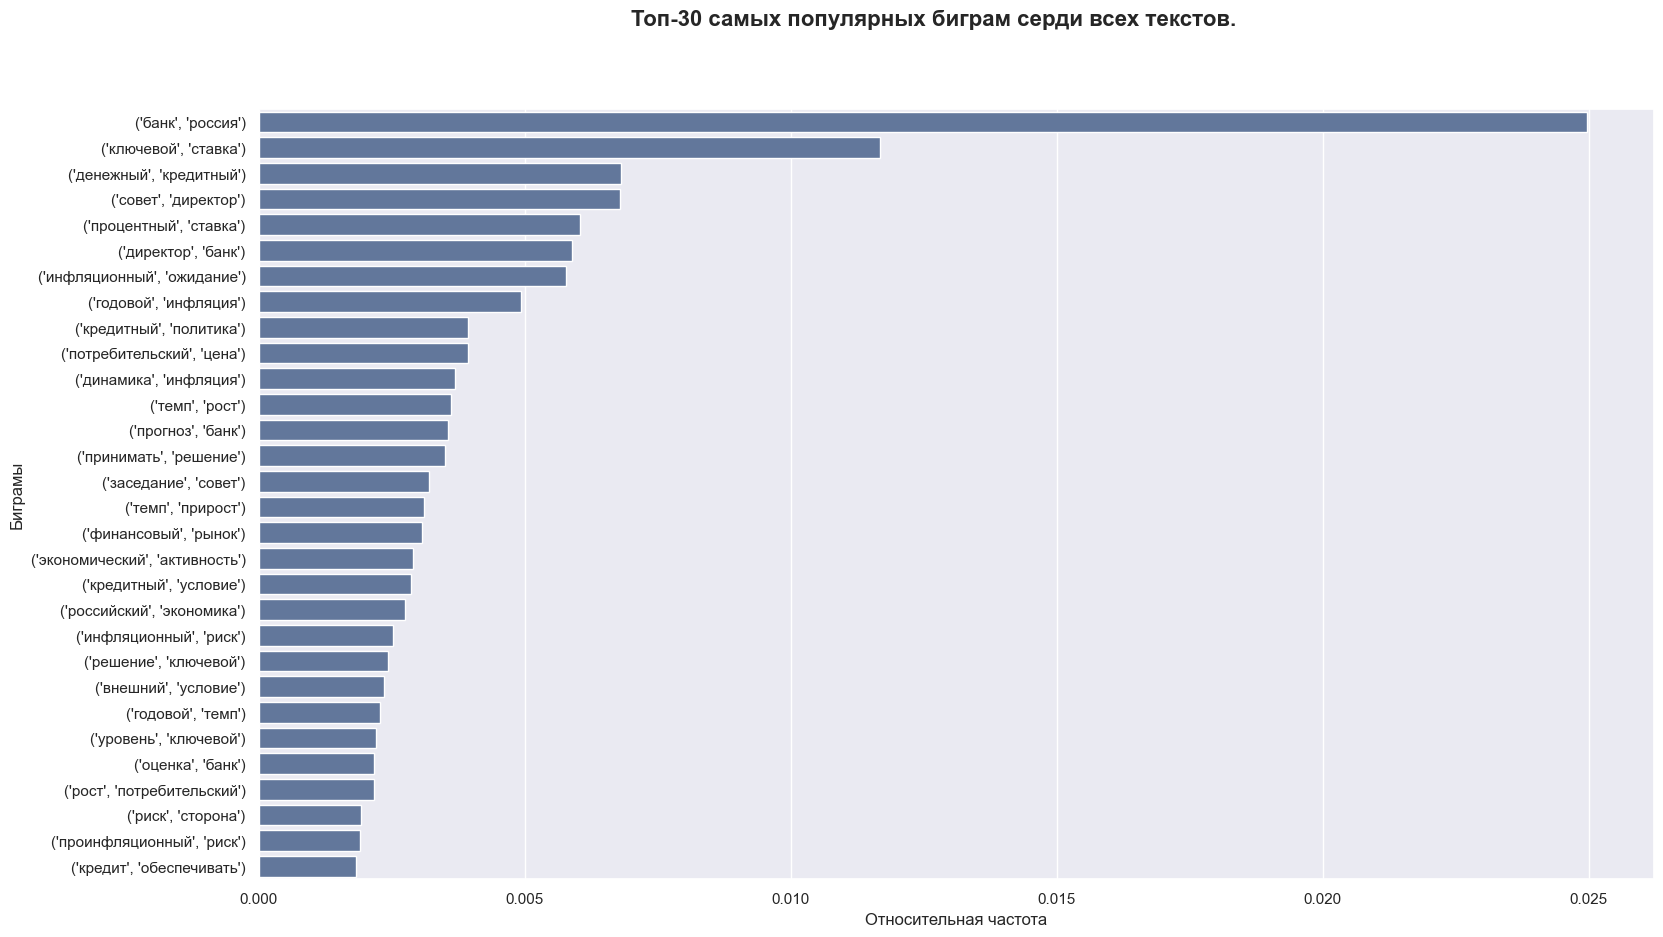

In [38]:
plot_all_words(
    pd.Series(cnt_bigram_all_class),
      'Топ-30 самых популярных биграм серди всех текстов.', 
      'Биграмы'
       )

Очень много общих слов которые не несут ценной информации. Найдем общие биграмы которые встречаются во всех классах.

In [39]:
common_bigrams = calc_common_words(cnt_bigram_neg_class, cnt_bigram_zero_class, cnt_bigram_pos_class)

Построим график частотности для каждого класса

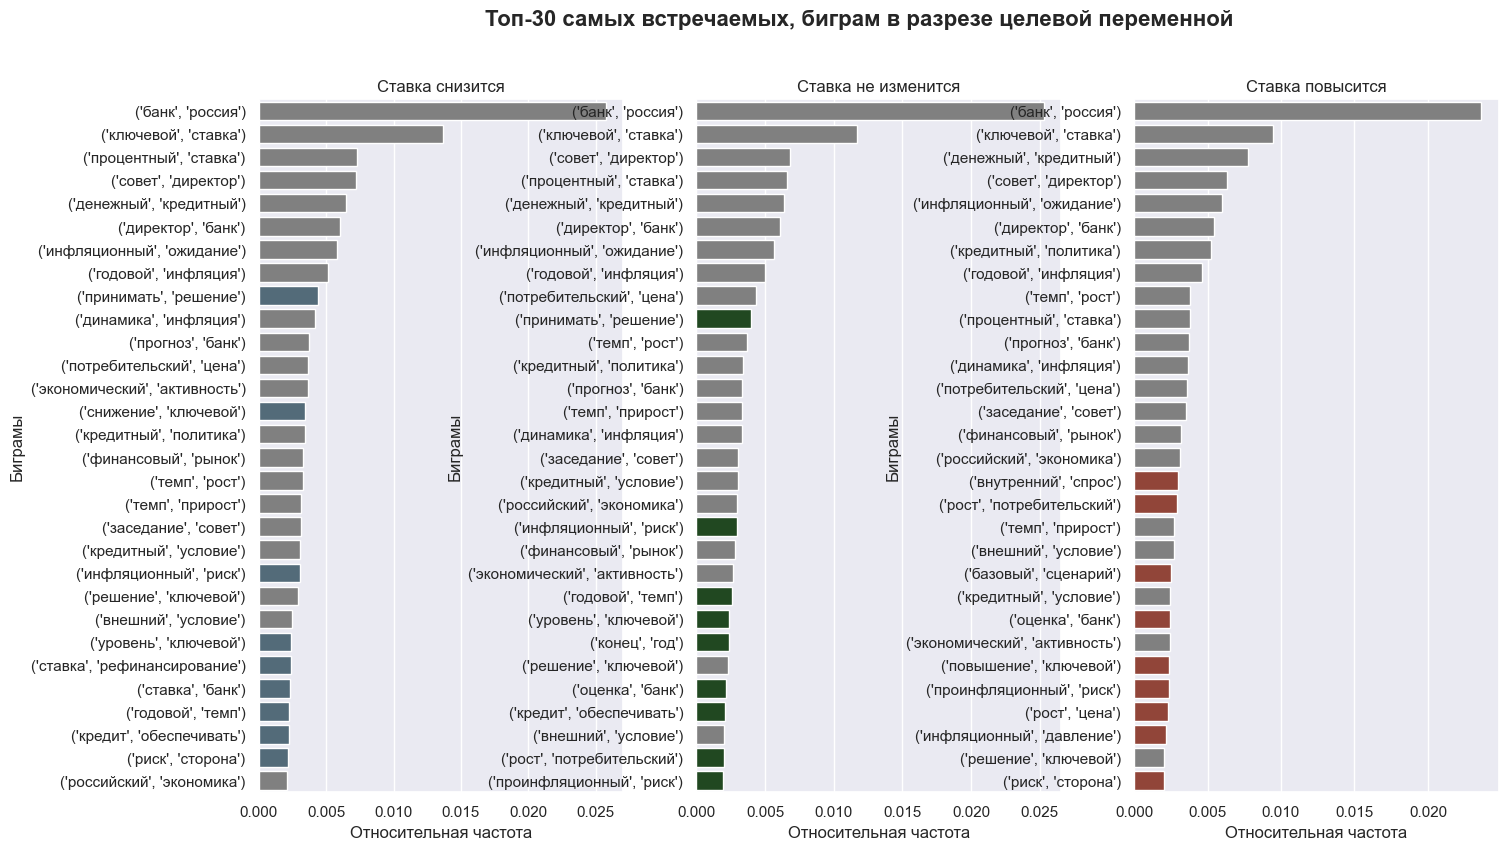

In [40]:
data = {-1: cnt_bigram_neg_class, 0: cnt_bigram_zero_class, 1: cnt_bigram_pos_class}
plot_words_per_class(
    data, 
    'Топ-30 самых встречаемых, биграм в разрезе целевой переменной',
     'Биграмы', 
     common_bigrams
     )

Почему-то при повышении ставки ЦБ реже употребляет слова - "принимать решение", но чаще использует "внутренний спрос", "потребительский рост". Давайте попробуем удалить биграмы есть во всех трех категориях.

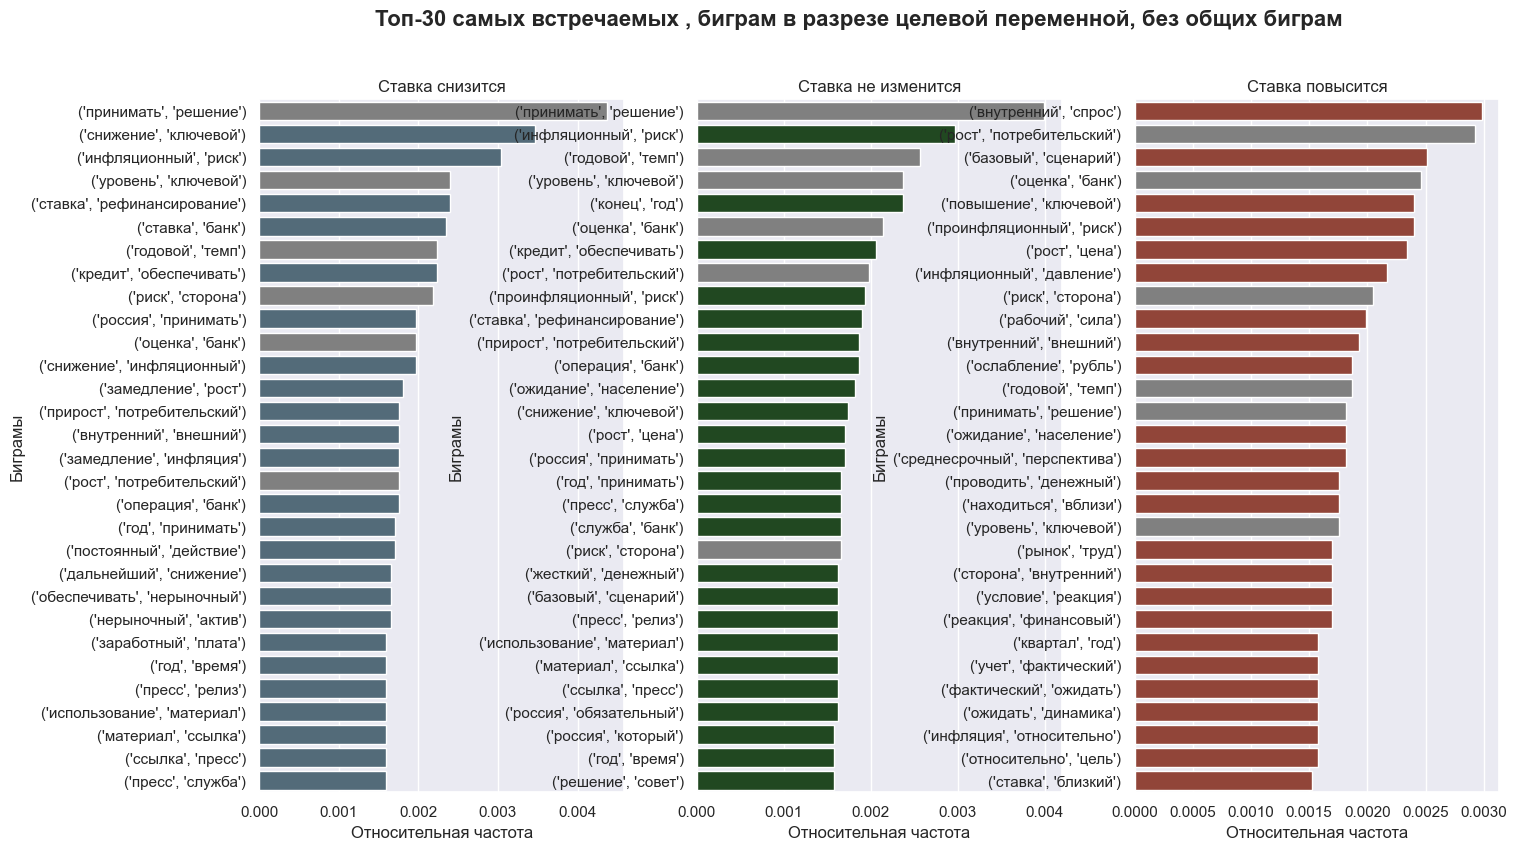

In [41]:
for bigram in common_bigrams:
    for value in data.values():
        del value[bigram]

common_bigrams = calc_common_words(cnt_bigram_neg_class, cnt_bigram_zero_class, cnt_bigram_pos_class)

plot_words_per_class(
    data,
    'Топ-30 самых встречаемых , биграм в разрезе целевой переменной, без общих биграм',
    'Биграмы',
    common_bigrams
)

"Ослабление рубля", "повышение ключевой", "проинфляционный риск", "рост цена" и др. характерны для решений о повышении ключевой ставки.
"Инфляционный риск", "кредит обеспечивать", "снижение ключевой", "ставка рефинансирования" и др. характерны для решений о снижении ключевой ставки.
Можем заметить, что по частоте биграм тексты за которыми следует снижение или сохранение ставки похожи между собой больше, чем тексты перед решениями о повышении ставки.
Проделаем все то же самое для триграм.

In [42]:
cnt_trigram_all_class = get_freq(nltk.ngrams(texts_all_class, 3))
cnt_trigram_all_class = {str(k): v for k, v in cnt_trigram_all_class.items()}
cnt_trigram_neg_class = get_freq(nltk.ngrams(texts_neg_class, 3))
cnt_trigram_neg_class = {str(k): v for k, v in cnt_trigram_neg_class.items()}
cnt_trigram_zero_class = get_freq(nltk.ngrams(texts_zero_class, 3))
cnt_trigram_zero_class = {str(k): v for k, v in cnt_trigram_zero_class.items()}
cnt_trigram_pos_class = get_freq(nltk.ngrams(texts_pos_class, 3))
cnt_trigram_pos_class = {str(k): v for k, v in cnt_trigram_pos_class.items()}

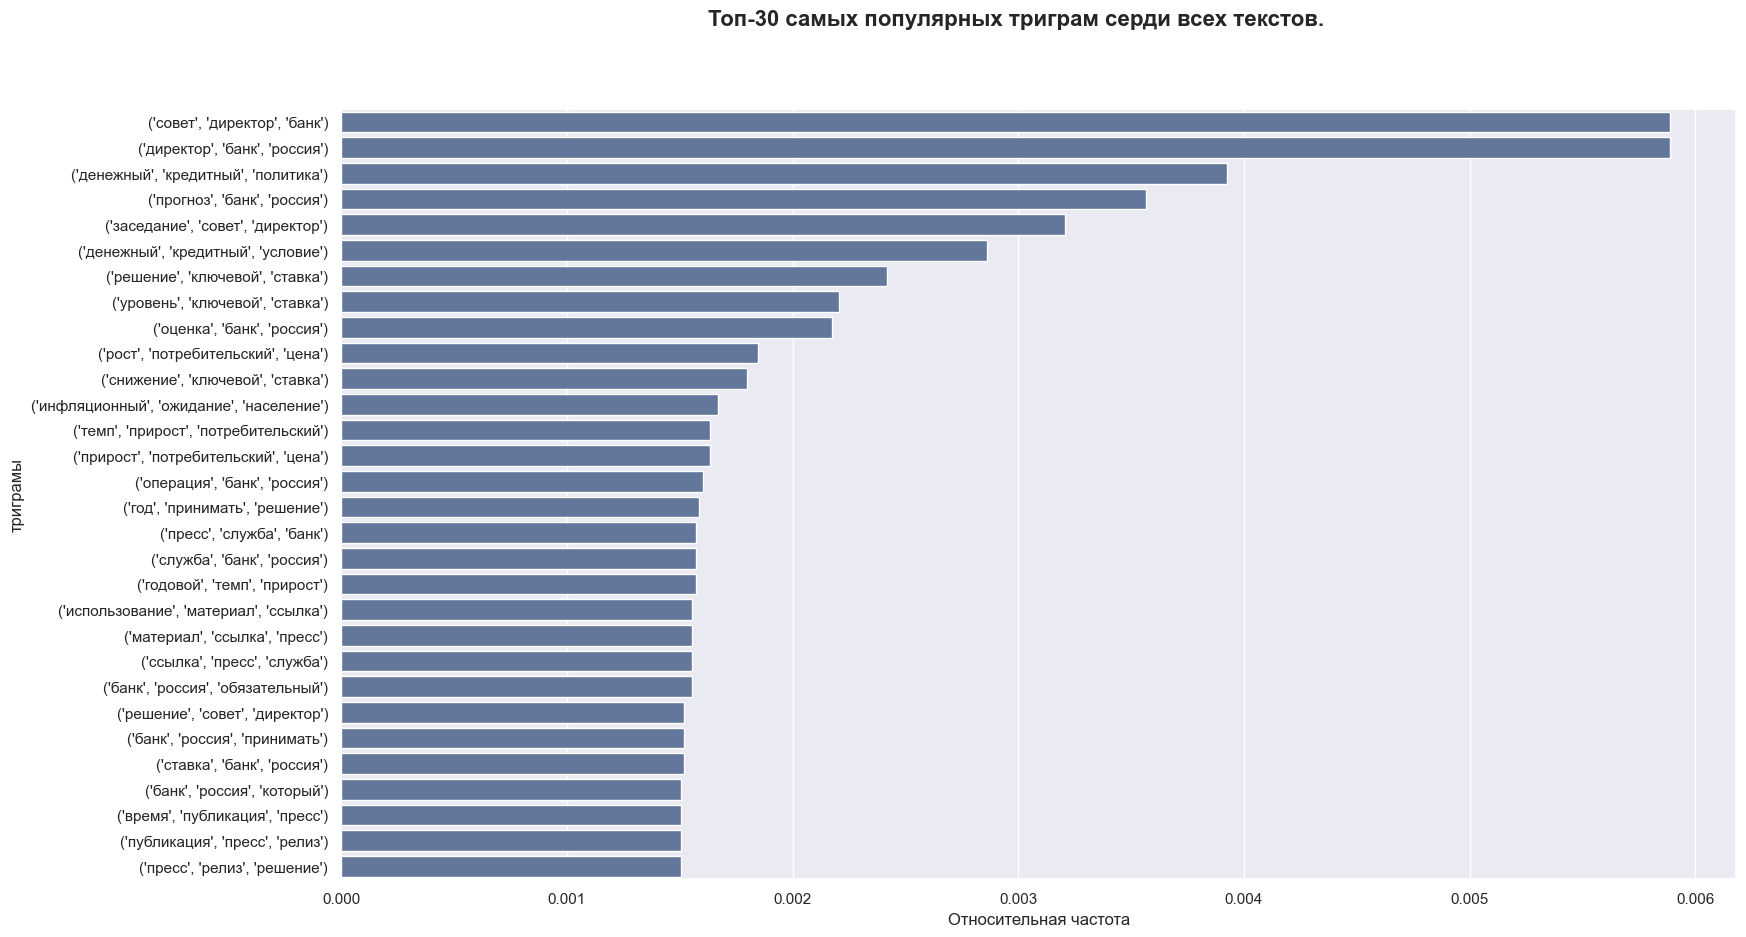

In [43]:
plot_all_words(
    pd.Series(cnt_trigram_all_class),
      'Топ-30 самых популярных триграм серди всех текстов.', 
      'триграмы'
       )

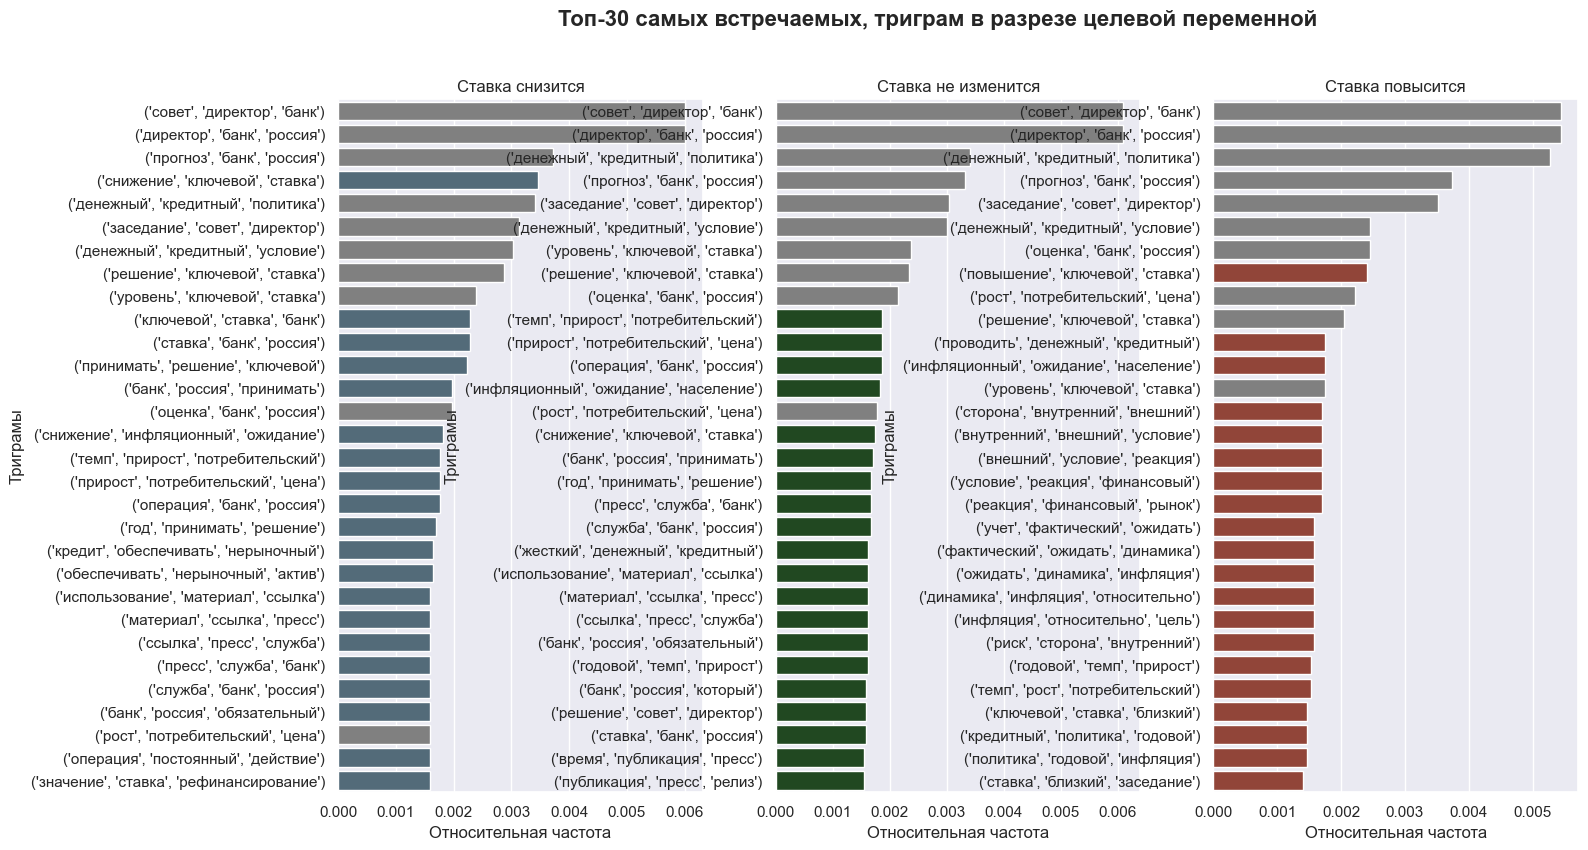

In [44]:
common_trigrams = calc_common_words(cnt_trigram_neg_class, cnt_trigram_zero_class, cnt_trigram_pos_class)

data = {-1: cnt_trigram_neg_class, 0: cnt_trigram_zero_class, 1: cnt_trigram_pos_class}
plot_words_per_class(
    data, 
    'Топ-30 самых встречаемых, триграм в разрезе целевой переменной', 
    'Триграмы', 
    common_trigrams
    )